In [1]:
import numpy as np
import xarray as xr
from tqdm.autonotebook import tqdm
import cmocean
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cartopy.crs as ccrs
from mask_regions import mask_inland_seas, mask_poles
from analysis_io import open_aslc_range, open_aslc_amax
from analysis import compute_future_change, wrap_argmonth_diff, compute_sign_agreement
from make_cartopy_maps import add_global_map_subplot, get_discrete_cmap
import gcsfs
from scipy.stats import circmean
fs = gcsfs.GCSFileSystem() #list stores, stripp zarr from filename, load 

/tmp/ipykernel_3091/2127128654.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
compute_ASLC_changes = False #whether to open pre-computed ASLC changes or compute them here

Store ASLC changes for quicker analysis later:

In [2]:
#open data and select ssp to plot
if compute_ASLC_changes:
    psmsl = xr.open_dataset('../month_means_1993_2022_psmsl.nc')
    psmsl = mask_poles(mask_inland_seas(psmsl))
    psmsl = psmsl.where(np.isfinite(psmsl.isel(month=0,drop=True)),drop=True)
    
    var = 'zos_ibe'
    
    for s,ssp in tqdm(enumerate(['ssp126','ssp245','ssp370','ssp585'])):
        exclude_models = ['INM-CM5-0','INM-CM4-8','GISS-E2-1-G','MIROC-ES2L'] #poorly performing models
        
        #open historical ASLC range and amax, excluding poorly performing models:
        aslc_range = open_aslc_range('gs://leap-persistent/timh37/CMIP6/aslc_1x1',{'lat':500,'lon':500,'period':1,'member_id':50,'experiment_id':4}).sel(experiment_id=ssp).drop_sel(source_id=exclude_models)#.load()
        aslc_range_tgs = open_aslc_range('gs://leap-persistent/timh37/CMIP6/aslc_psmsl',{'tg':1000,'period':2,'member_id':200}).sel(experiment_id=ssp).drop_sel(source_id=exclude_models).load()
        
        aslc_amax = open_aslc_amax('gs://leap-persistent/timh37/CMIP6/aslc_1x1',{'lat':500,'lon':500,'period':1,'member_id':50,'experiment_id':4}).sel(experiment_id=ssp).drop_sel(source_id=exclude_models)#.load()
        aslc_amax_tgs = open_aslc_amax('gs://leap-persistent/timh37/CMIP6/aslc_psmsl',{'tg':1000,'period':2,'member_id':200}).sel(experiment_id=ssp).drop_sel(source_id=exclude_models).load()
        
        #mask out where less than 10 models are ocean
        more_than_10_models = np.isfinite(aslc_range.zos_ibe).any(dim='member_id').sum(dim='source_id')>=10 #mask for gridded fields where less than 10 models have data
        
        #3): mask out poles and inland seas
        aslc_range = mask_poles( mask_inland_seas( aslc_range.where(more_than_10_models) ) )
        aslc_range_tgs = mask_poles( mask_inland_seas( aslc_range_tgs ) )
        
        aslc_amax = mask_poles( mask_inland_seas( aslc_amax.where(more_than_10_models) ) ) 
        aslc_amax_tgs = mask_poles( mask_inland_seas( aslc_amax_tgs ) )
        
        #Compute future ASLC changes
        aslc_range_change = (compute_future_change(aslc_range[var]))
        aslc_range_change_tgs = (compute_future_change(aslc_range_tgs[var]))
        
        aslc_amax_change = (wrap_argmonth_diff(compute_future_change(aslc_amax[var])))
        aslc_amax_change_tgs = wrap_argmonth_diff(compute_future_change(aslc_amax_tgs[var]))
    
        ###store for global
        #absolute range changes
        aslc_change = aslc_range_change.to_dataset(name='range_change')
        aslc_change['amax_change'] = aslc_amax_change
    
        aslc_change['member_id'] = aslc_change['member_id'].astype('str')
        aslc_change['source_id'] = aslc_change['source_id'].astype('str')
        aslc_change['experiment_id'] = aslc_change['experiment_id'].astype('str')
        
        aslc_change.to_zarr('gs://leap-persistent/timh37/CMIP6/aslc_change/'+var+'_aslc_change_1x1_'+ssp+'.zarr',mode='w',zarr_format=2) #circumvent issues with zarr3
    
        #relative range changes
        aslc_rel_change = aslc_change
        aslc_rel_change['range_change'] = 100*aslc_rel_change['range_change']/aslc_range[var].sel(period='hist')
        
        aslc_rel_change.to_zarr('gs://leap-persistent/timh37/CMIP6/aslc_relative_change/'+var+'_aslc_change_1x1_'+ssp+'.zarr',mode='w',zarr_format=2) #circumvent issues with zarr3
        
        ###store for tide gauges
        #absolute range changes
        aslc_change_tgs = aslc_range_change_tgs.to_dataset(name='range_change')
        aslc_change_tgs['amax_change'] = aslc_amax_change_tgs
        
        aslc_change_tgs['member_id'] = aslc_change_tgs['member_id'].astype('str')
        aslc_change_tgs['source_id'] = aslc_change_tgs['source_id'].astype('str')
        aslc_change_tgs['experiment_id'] = aslc_change_tgs['experiment_id'].astype('str')
        aslc_change_tgs['tg'] = aslc_change_tgs['tg'].astype('str')
    
        aslc_change_tgs.to_zarr('gs://leap-persistent/timh37/CMIP6/aslc_change/'+var+'_aslc_change_psmsl_'+ssp+'.zarr',mode='w',zarr_format=2) #circumvent issues with zarr3
        
        #relative range changes
        aslc_rel_change_tgs = aslc_change_tgs
        aslc_rel_change_tgs['range_change'] = 100*aslc_rel_change_tgs['range_change']/aslc_range_tgs[var].sel(period='hist')
        
        aslc_rel_change_tgs.to_zarr('gs://leap-persistent/timh37/CMIP6/aslc_relative_change/'+var+'_aslc_change_psmsl_'+ssp+'.zarr',mode='w',zarr_format=2) #circumvent issues with zarr3
else: #open stored files:
    fns = ['gs://'+k for k in fs.ls('gs://leap-persistent/timh37/CMIP6/aslc_change/') if 'change_1x1' in k]
    aslc_change = xr.open_mfdataset(fns,
                                 combine='nested',coords='minimal',compat='override',concat_dim = 'experiment_id',engine='zarr').load()
    
    fns = ['gs://'+k for k in fs.ls('gs://leap-persistent/timh37/CMIP6/aslc_change/') if 'change_psmsl' in k]
    aslc_change_tgs = xr.open_mfdataset(fns,
                                 combine='nested',coords='minimal',compat='override',concat_dim = 'experiment_id',engine='zarr').load()   

0it [00:00, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/core/metadata/v2.py:192: UserWarning: Found an empty list of filters in the array metadata document. This is contrary to the Zarr V2 specification, and will cause an error in the future. Use None (or Null in a JSON document) instead of an empty list of filters.
  warnings.warn(msg, UserWarning, stacklevel=1)
/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/core/metadata/v2.py:192: UserWarning: Found an empty list of filters in the array metadata document. This is contrary to the Zarr V2 specification, and will cause an error in the future. Use None (or Null in a JSON document) instead of an empty list of filters.
  warnings.warn(msg, UserWarning, stacklevel=1)
/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/core/metadata/v2.py:192: UserWarning: Found an empty list of filters in the array metadata document. This is contrary to the Zarr V2 specification, and will cause an error in the future. Use None (or Nul

In [4]:
#compute sign agreement among models on the changes
sign_agreement_aslc_changes = compute_sign_agreement(aslc_change.mean(dim='member_id'),'source_id',2/3)
sign_agreement_aslc_changes_tgs = compute_sign_agreement(aslc_change_tgs.mean(dim='member_id'),'source_id',2/3)

Uncertainty analysis:

In [5]:
#compute uncertainty reduction through using multiple members:
unc_reduction=[]
unc_reduction_tgs=[]
for s in ['ssp126','ssp245','ssp370','ssp585']:
    finite_mems = np.isfinite(aslc_change_tgs.range_change.isel(id=0).sel(experiment_id=s))
    
    members= np.zeros((len(aslc_change_tgs.range_change.source_id)))
    for i in np.arange(len(aslc_change_tgs.range_change.source_id)):
        try:
            members[i] = np.where(finite_mems[i,:])[0][0]
        except:
            members[i] = 0
    ix = xr.DataArray(members,dims=['source_id'],coords={'source_id':aslc_change_tgs.range_change.source_id}).astype('int')

    range_a = (aslc_change.range_change.sel(experiment_id=s).mean(dim='member_id').quantile(.83,dim='source_id') - aslc_change.range_change.sel(experiment_id=s).mean(dim='member_id').quantile(.17,dim='source_id'))
    range_b = (aslc_change.range_change.sel(experiment_id=s).isel(member_id=ix.astype('int')).quantile(.83,dim='source_id') - aslc_change.range_change.sel(experiment_id=s).isel(member_id=ix.astype('int')).quantile(.17,dim='source_id'))
    
    unc_reduction.append(100*(range_a - range_b)/range_b)

    range_a = (aslc_change_tgs.range_change.sel(experiment_id=s).mean(dim='member_id').quantile(.83,dim='source_id') - aslc_change_tgs.range_change.sel(experiment_id=s).mean(dim='member_id').quantile(.17,dim='source_id'))
    range_b = (aslc_change_tgs.range_change.sel(experiment_id=s).isel(member_id=ix.astype('int')).quantile(.83,dim='source_id') - aslc_change_tgs.range_change.sel(experiment_id=s).isel(member_id=ix.astype('int')).quantile(.17,dim='source_id'))
    
    unc_reduction_tgs.append(100*(range_a - range_b)/range_b)

#compute model consensus on sign of change
frac_positive = (aslc_change.mean(dim='member_id')>=0).sum(dim='source_id')/np.isfinite(aslc_change.mean(dim='member_id')).sum(dim='source_id')
frac_positive_tgs = (aslc_change_tgs.mean(dim='member_id')>=0).sum(dim='source_id')/np.isfinite(aslc_change_tgs.mean(dim='member_id')).sum(dim='source_id')

Text(0.5, 1.0, '(c) Effect of initial-condition variants')

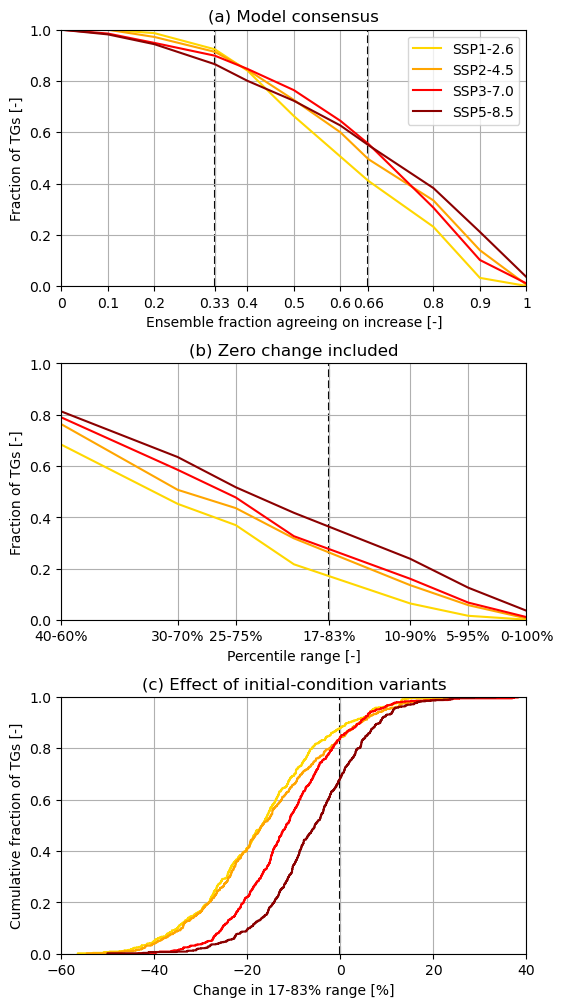

In [7]:
save_fig = 0

fig = plt.figure(figsize=(6,12))
gs2 = fig.add_gridspec(3,1,hspace=.3)

ax1 = fig.add_subplot(gs2[0,0])

for s,ssp in enumerate(['ssp126','ssp245','ssp370','ssp585']):
    num_robust_ssp=[]
    for frac in [0,.1,.2,.33,.4,.5,.6,.66,.8,.9,1]:
        num_robust = (frac_positive_tgs.range_change.sel(experiment_id=ssp)>=frac).sum(dim='id')/np.isfinite(frac_positive_tgs.range_change.sel(experiment_id=ssp)).sum(dim='id')
        num_robust_ssp.append(num_robust)
    ax1.plot([0,.1,.2,.33,.4,.5,.6,.66,.8,.9,1],num_robust_ssp,color=['gold','orange','red','darkred'][s],label=['SSP1-2.6','SSP2-4.5','SSP3-7.0','SSP5-8.5'][s])
        #plt.scatter(frac,1-num_robust,color=['gold','orange','red','darkred'][s])
ax1.set_ylim(0,1)
ax1.set_xlim(0,1)
ax1.axvline(x=.33,zorder=0,linestyle='dashed',color='black')
ax1.axvline(x=.66,zorder=0,linestyle='dashed',color='black')
ax1.grid()
ax1.set_ylabel('Fraction of TGs [-]')
ax1.set_xlabel('Ensemble fraction agreeing on increase [-]')
ax1.set_title('(a) Model consensus')
ax1.set_xticks([0,.1,.2,.33,.4,.5,.6,.66,.8,.9,1],[str(k) for k in [0,.1,.2,.33,.4,.5,.6,.66,.8,.9,1]])
ax1.legend()

ax1 = fig.add_subplot(gs2[1,0])
for s,ssp in enumerate(['ssp126','ssp245','ssp370','ssp585']):
    num_significant_ssp=[]
    for range_width in [.2,.4,.5,.66,.8,.90,1]:
        num_sig = (np.sign(aslc_change_tgs.range_change.sel(experiment_id=ssp).mean(dim='member_id').quantile(1-(1-range_width)/2,dim='source_id')) == np.sign(aslc_change_tgs.range_change.sel(experiment_id=ssp).mean(dim='member_id').quantile(0+(1-range_width)/2,dim='source_id'))).sum(dim='id')
        num_significant_ssp.append(num_sig/np.isfinite(aslc_change_tgs.range_change.sel(experiment_id=ssp).mean(dim='member_id').median(dim='source_id')).sum(dim='id'))

    ax1.plot([.2,.4,.5,.6,.8,.90,1],num_significant_ssp,color=['gold','orange','red','darkred'][s],label=['SSP1-2.6','SSP2-4.5','SSP3-7.0','SSP5-8.5'][s])
       
ax1.set_ylim(0,1)
ax1.set_xlim(.2,1)
ax1.grid()
ax1.axvline(x=.66,zorder=0,linestyle='dashed',color='black')
ax1.set_ylabel('Fraction of TGs [-]')
ax1.set_xlabel('Percentile range [-]')
ax1.set_title('(b) Zero change included')
ax1.set_xticks([.2,.4,.5,.66,.8,.90,1],['40-60%','30-70%','25-75%','17-83%','10-90%','5-95%','0-100%'],rotation=0)

import seaborn as sns
total_num = len(unc_reduction_tgs)

ax1 = fig.add_subplot(gs2[2,0])
for i,k in enumerate(unc_reduction_tgs):

    sns.ecdfplot(data=k,ax=ax1,color=['gold','orange','red','darkred'][i],label=['SSP1-2.6','SSP2-4.5','SSP3-7.0','SSP5-8.5'][i])
    #ax1.axvline(x=k.mean(),color=['gold','orange','red','darkred'][i],linestyle='dotted',alpha=.5,zorder=3)
ax1.axvline(x=0,zorder=0,color='black',linestyle='dashed')
ax1.grid()

ax1.set_xlim(-60,40)

ax1.set_ylabel('Cumulative fraction of TGs [-]')
ax1.set_xlabel('Change in 17-83% range [%]')
ax1.set_title('(c) Effect of initial-condition variants')
if save_fig:
    #fig.savefig('figures/uncertainty_analysis.pdf',format='pdf',dpi=300,bbox_inches='tight')

Plot absolute range change for all SSPs:

/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)


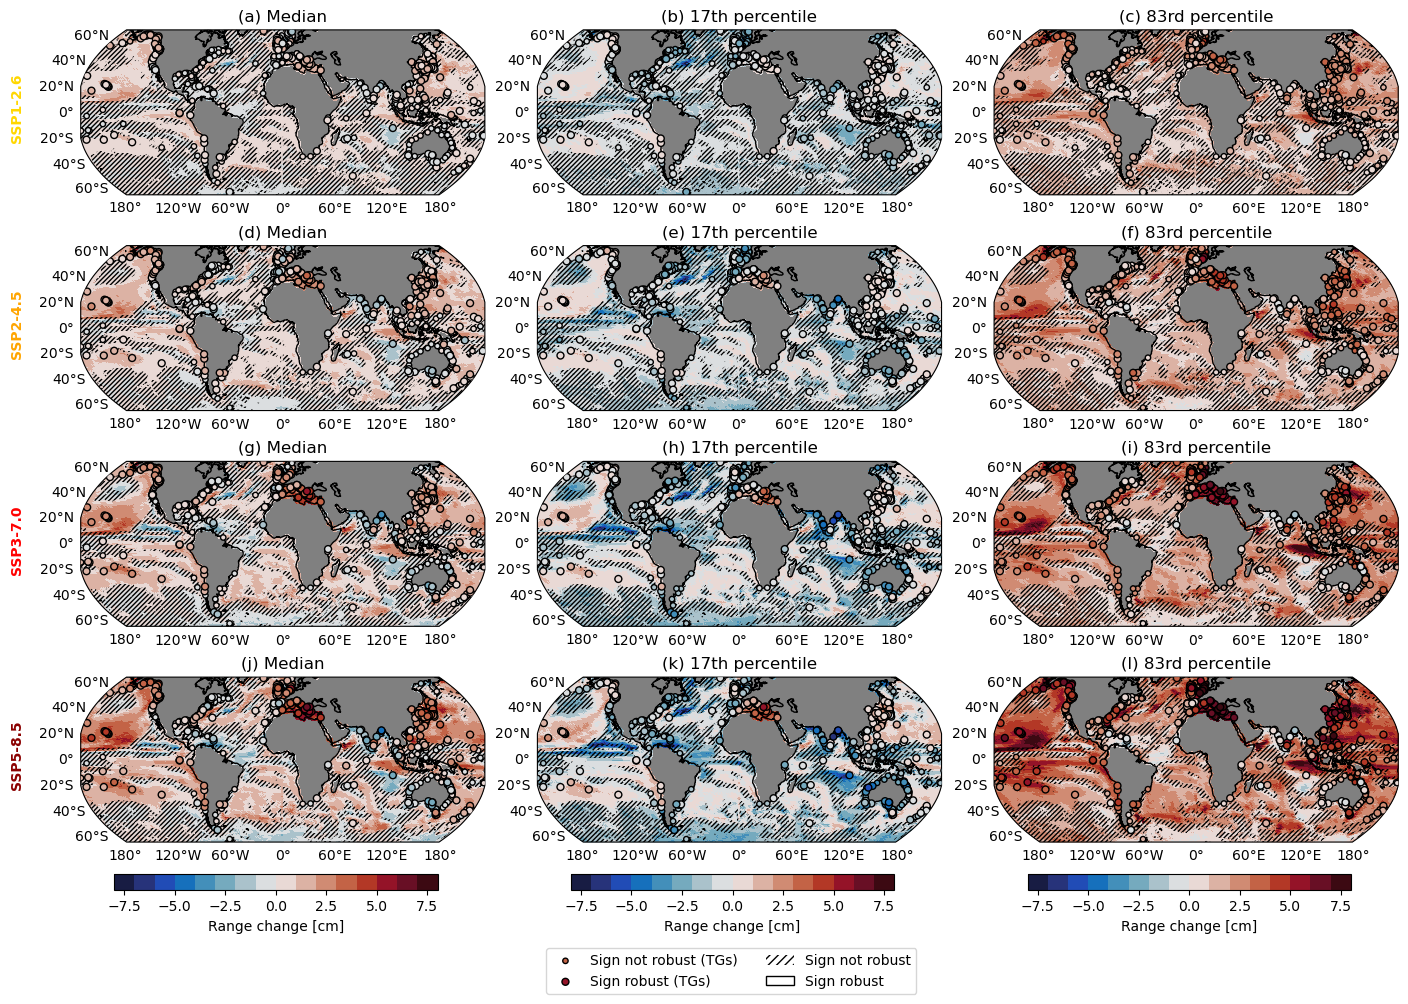

In [8]:
balance_discrete1 = get_discrete_cmap(cmocean.cm.balance, 16)

vmin_range = -8
vmax_range = 8

fig = plt.figure(figsize=(17,11))
gs = fig.add_gridspec(4,3)
gs.update(hspace=.08)
gs.update(wspace=.13)

for s,ssp in enumerate(['ssp126','ssp245','ssp370','ssp585']):
    
    if s==3:
        plot_cbar = 'below'
    else:
        plot_cbar = False

    #median
    fig,ax = add_global_map_subplot(fig,aslc_change.range_change.sel(experiment_id=ssp).mean(dim='member_id').median(dim='source_id'),
                                 gs[s,0],vmin_range,vmax_range,balance_discrete1,['(a)','(d)','(g)','(j)'][s]+' Median',sign_agreement_aslc_changes.range_change.sel(experiment_id=ssp)==False,plot_cbar,'Range change [cm]')
    ax.set_facecolor("gray")
   
    s1=ax.scatter(aslc_change_tgs.lon[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==False],aslc_change_tgs.lat[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==False],
              c=aslc_change_tgs.range_change.sel(experiment_id=ssp).mean(dim='member_id').median(dim='source_id')[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==False],
               vmin=vmin_range,vmax=vmax_range,cmap=balance_discrete1,edgecolor='black',s=15,marker='o',transform=ccrs.PlateCarree(),zorder=5,label='Sign not robust (TGs)')
    s2=ax.scatter(aslc_change_tgs.lon[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==True],aslc_change_tgs.lat[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==True],
              c=aslc_change_tgs.range_change.sel(experiment_id=ssp).mean(dim='member_id').median(dim='source_id')[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==True],
               vmin=vmin_range,vmax=vmax_range,cmap=balance_discrete1,edgecolor='black',s=25,marker='o',transform=ccrs.PlateCarree(),zorder=5,label='Sign robust (TGs)')
    
    ax.annotate(['SSP1-2.6','SSP2-4.5','SSP3-7.0','SSP5-8.5'][s], (-.175,.335), xycoords='axes fraction',rotation=90,fontweight='bold',color=['gold','orange','red','darkred'][s])

    #5%
    fig,ax = add_global_map_subplot(fig,aslc_change.range_change.sel(experiment_id=ssp).mean(dim='member_id').quantile(.17,dim='source_id'),
                                 gs[s,1],vmin_range,vmax_range,balance_discrete1,['(b)','(e)','(h)','(k)'][s]+' 17th percentile',sign_agreement_aslc_changes.range_change.sel(experiment_id=ssp)==False,plot_cbar,'Range change [cm]')
    ax.set_facecolor("gray")
    s1=ax.scatter(aslc_change_tgs.lon[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==False],aslc_change_tgs.lat[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==False],
              c=aslc_change_tgs.range_change.sel(experiment_id=ssp).mean(dim='member_id').quantile(.17,dim='source_id')[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==False],
               vmin=vmin_range,vmax=vmax_range,cmap=balance_discrete1,edgecolor='black',s=15,marker='o',transform=ccrs.PlateCarree(),zorder=5,label='Sign not robust (TGs)')
    s2=ax.scatter(aslc_change_tgs.lon[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==True],aslc_change_tgs.lat[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==True],
              c=aslc_change_tgs.range_change.sel(experiment_id=ssp).mean(dim='member_id').quantile(.17,dim='source_id')[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==True],
               vmin=vmin_range,vmax=vmax_range,cmap=balance_discrete1,edgecolor='black',s=25,marker='o',transform=ccrs.PlateCarree(),zorder=5,label='Sign robust (TGs)')

    #95%
    fig,ax = add_global_map_subplot(fig,aslc_change.range_change.sel(experiment_id=ssp).mean(dim='member_id').quantile(.83,dim='source_id'),
                                 gs[s,2],vmin_range,vmax_range,balance_discrete1,['(c)','(f)','(i)','(l)'][s]+' 83rd percentile',sign_agreement_aslc_changes.range_change.sel(experiment_id=ssp)==False,plot_cbar,'Range change [cm]')
    ax.set_facecolor("gray")
    s1=ax.scatter(aslc_change_tgs.lon[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==False],aslc_change_tgs.lat[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==False],
              c=aslc_change_tgs.range_change.sel(experiment_id=ssp).mean(dim='member_id').quantile(.83,dim='source_id')[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==False],
               vmin=vmin_range,vmax=vmax_range,cmap=balance_discrete1,edgecolor='black',s=15,marker='o',transform=ccrs.PlateCarree(),zorder=5,label='Sign not robust (TGs)')
    s2=ax.scatter(aslc_change_tgs.lon[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==True],aslc_change_tgs.lat[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==True],
              c=aslc_change_tgs.range_change.sel(experiment_id=ssp).mean(dim='member_id').quantile(.83,dim='source_id')[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==True],
               vmin=vmin_range,vmax=vmax_range,cmap=balance_discrete1,edgecolor='black',s=25,marker='o',transform=ccrs.PlateCarree(),zorder=5,label='Sign robust (TGs)')

#add legend
import matplotlib.patches as mpatches
hatching = mpatches.Patch( facecolor='white',hatch=r'////',label='Sign not robust')
no_hatching = mpatches.Patch( facecolor='white',edgecolor='black',hatch=None,label='Sign robust')
ax.legend(handles = [s1,s2,hatching,no_hatching],bbox_to_anchor=(-.475, -1.1, 0.3, 0.5),ncols=2)

fig.savefig('figures/aslc_range_change_zos_ibe_all_ssps.jpg',format='jpg',dpi=300,bbox_inches='tight')


Plot relative changes for all SSPs:

In [9]:
fns = ['gs://'+k for k in fs.ls('gs://leap-persistent/timh37/CMIP6/aslc_relative_change/') if 'change_1x1' in k]
aslc_change = xr.open_mfdataset(fns,
                             combine='nested',coords='minimal',compat='override',concat_dim = 'experiment_id',engine='zarr').load()

fns = ['gs://'+k for k in fs.ls('gs://leap-persistent/timh37/CMIP6/aslc_relative_change/') if 'change_psmsl' in k]
aslc_change_tgs = xr.open_mfdataset(fns,
                             combine='nested',coords='minimal',compat='override',concat_dim = 'experiment_id',engine='zarr').load()

In [10]:
#compute sign agreement among models on the changes
sign_agreement_aslc_changes = compute_sign_agreement(aslc_change.mean(dim='member_id'),'source_id',2/3)
sign_agreement_aslc_changes_tgs = compute_sign_agreement(aslc_change_tgs.mean(dim='member_id'),'source_id',2/3)

/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)


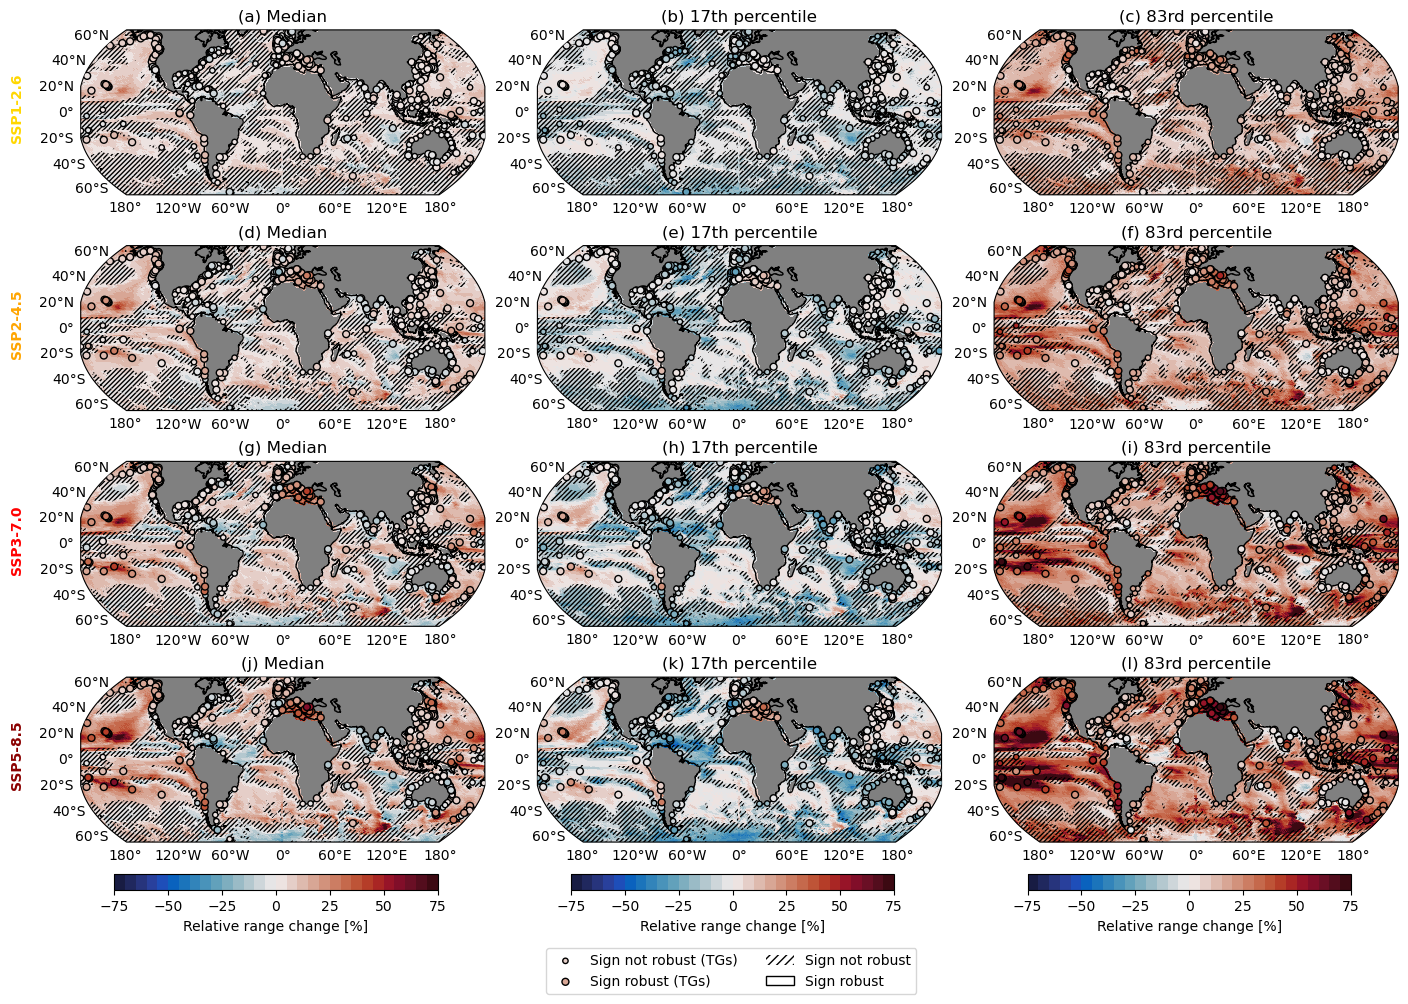

In [11]:
store_fig = 0
balance_discrete1 = get_discrete_cmap(cmocean.cm.balance, 30)

vmin_range = -75
vmax_range = 75

fig = plt.figure(figsize=(17,11))
gs = fig.add_gridspec(4,3)
gs.update(hspace=.08)
gs.update(wspace=.13)

for s,ssp in enumerate(['ssp126','ssp245','ssp370','ssp585']):
    
    if s==3:
        plot_cbar = 'below'
    else:
        plot_cbar = False

    #median
    fig,ax = add_global_map_subplot(fig,aslc_change.range_change.sel(experiment_id=ssp).mean(dim='member_id').median(dim='source_id'),
                                 gs[s,0],vmin_range,vmax_range,balance_discrete1,['(a)','(d)','(g)','(j)'][s]+' Median',sign_agreement_aslc_changes.range_change.sel(experiment_id=ssp)==False,plot_cbar,'Relative range change [%]')
    ax.set_facecolor("gray")
   
    s1=ax.scatter(aslc_change_tgs.lon[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==False],aslc_change_tgs.lat[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==False],
              c=aslc_change_tgs.range_change.sel(experiment_id=ssp).mean(dim='member_id').median(dim='source_id')[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==False],
               vmin=vmin_range,vmax=vmax_range,cmap=balance_discrete1,edgecolor='black',s=15,marker='o',transform=ccrs.PlateCarree(),zorder=5,label='Sign not robust (TGs)')
    s2=ax.scatter(aslc_change_tgs.lon[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==True],aslc_change_tgs.lat[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==True],
              c=aslc_change_tgs.range_change.sel(experiment_id=ssp).mean(dim='member_id').median(dim='source_id')[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==True],
               vmin=vmin_range,vmax=vmax_range,cmap=balance_discrete1,edgecolor='black',s=25,marker='o',transform=ccrs.PlateCarree(),zorder=5,label='Sign robust (TGs)')
    
    ax.annotate(['SSP1-2.6','SSP2-4.5','SSP3-7.0','SSP5-8.5'][s], (-.175,.335), xycoords='axes fraction',rotation=90,fontweight='bold',color=['gold','orange','red','darkred'][s])

    #5%
    fig,ax = add_global_map_subplot(fig,aslc_change.range_change.sel(experiment_id=ssp).mean(dim='member_id').quantile(.17,dim='source_id'),
                                 gs[s,1],vmin_range,vmax_range,balance_discrete1,['(b)','(e)','(h)','(k)'][s]+' 17th percentile',sign_agreement_aslc_changes.range_change.sel(experiment_id=ssp)==False,plot_cbar,'Relative range change [%]')
    ax.set_facecolor("gray")
    s1=ax.scatter(aslc_change_tgs.lon[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==False],aslc_change_tgs.lat[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==False],
              c=aslc_change_tgs.range_change.sel(experiment_id=ssp).mean(dim='member_id').quantile(.17,dim='source_id')[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==False],
               vmin=vmin_range,vmax=vmax_range,cmap=balance_discrete1,edgecolor='black',s=15,marker='o',transform=ccrs.PlateCarree(),zorder=5,label='Sign not robust (TGs)')
    s2=ax.scatter(aslc_change_tgs.lon[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==True],aslc_change_tgs.lat[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==True],
              c=aslc_change_tgs.range_change.sel(experiment_id=ssp).mean(dim='member_id').quantile(.17,dim='source_id')[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==True],
               vmin=vmin_range,vmax=vmax_range,cmap=balance_discrete1,edgecolor='black',s=25,marker='o',transform=ccrs.PlateCarree(),zorder=5,label='Sign robust (TGs)')

    #95%
    fig,ax = add_global_map_subplot(fig,aslc_change.range_change.sel(experiment_id=ssp).mean(dim='member_id').quantile(.83,dim='source_id'),
                                 gs[s,2],vmin_range,vmax_range,balance_discrete1,['(c)','(f)','(i)','(l)'][s]+' 83rd percentile',sign_agreement_aslc_changes.range_change.sel(experiment_id=ssp)==False,plot_cbar,'Relative range change [%]')
    ax.set_facecolor("gray")
    s1=ax.scatter(aslc_change_tgs.lon[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==False],aslc_change_tgs.lat[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==False],
              c=aslc_change_tgs.range_change.sel(experiment_id=ssp).mean(dim='member_id').quantile(.83,dim='source_id')[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==False],
               vmin=vmin_range,vmax=vmax_range,cmap=balance_discrete1,edgecolor='black',s=15,marker='o',transform=ccrs.PlateCarree(),zorder=5,label='Sign not robust (TGs)')
    s2=ax.scatter(aslc_change_tgs.lon[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==True],aslc_change_tgs.lat[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==True],
              c=aslc_change_tgs.range_change.sel(experiment_id=ssp).mean(dim='member_id').quantile(.83,dim='source_id')[sign_agreement_aslc_changes_tgs.range_change.sel(experiment_id=ssp)==True],
               vmin=vmin_range,vmax=vmax_range,cmap=balance_discrete1,edgecolor='black',s=25,marker='o',transform=ccrs.PlateCarree(),zorder=5,label='Sign robust (TGs)')

#add legend
import matplotlib.patches as mpatches
hatching = mpatches.Patch( facecolor='white',hatch=r'////',label='Sign not robust')
no_hatching = mpatches.Patch( facecolor='white',edgecolor='black',hatch=None,label='Sign robust')
ax.legend(handles = [s1,s2,hatching,no_hatching],bbox_to_anchor=(-.475, -1.1, 0.3, 0.5),ncols=2)

if store_fig:
    fig.savefig('figures/aslc_range_relative_change_zos_ibe_all_ssps.jpg',format='jpg',dpi=300,bbox_inches='tight')
